# Style Transfer with PyTorch

In [1]:
%matplotlib inline

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms as tf
import torch.nn.functional as F

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

All pre-trained models in PyTorch expect input images pixels to be in the [0, 1] range normalized using this mean and std:  
<b>mean = (0.485, 0.456, 0.406)  
std = (0.229, 0.224, 0.225)</b>

In [4]:
def transformation(img, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    
    tasks = tf.Compose([
        tf.Resize(256),
        tf.ToTensor(),
        tf.Normalize(mean, std)
    ])
    
    img = tasks(img)
    img = img.unsqueeze(0)
    
    return img
    

In [5]:
content_img = Image.open("cat.jpg").convert("RGB")
style_img = Image.open("starry_night.jpg").convert("RGB")

In [6]:
content_img = transformation(content_img).to(device)
style_img = transformation(style_img).to(device)

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [8]:
def tensor_to_image(tensor, mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)):
    
    unorm = UnNormalize(mean = mean, std = std)
    image = unorm(tensor)
    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()
    
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    
    return image    

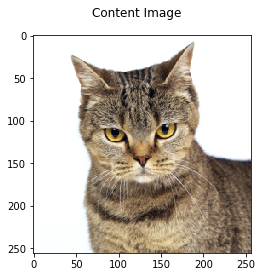

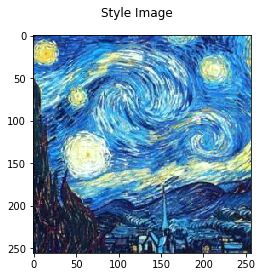

In [9]:
img = tensor_to_image(content_img)
fig = plt.figure()
fig.suptitle("Content Image")
plt.imshow(img)

img = tensor_to_image(style_img)
fig = plt.figure()
fig.suptitle("Style Image")
plt.imshow(img)

In [10]:
LAYERS_OF_INTEREST = {'0': 'conv1_1',
                      '5': 'conv2_1',
                      '10': 'conv3_1',
                      '19': 'conv4_1',
                      '21': 'conv4_2',
                      '28': 'conv5_1'}

In [11]:
def apply_model_and_extract_features(image, model):
    
    x = image
    
    features = {}
    
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x
            
    return features

In [12]:
content_img_features = apply_model_and_extract_features(content_img, vgg)
style_img_features = apply_model_and_extract_features(style_img, vgg)

In [13]:
def calculate_gram_matrix(tensor):
    
    _, channels, height, width = tensor.size()
    
    tensor = tensor.view(channels, height * width)
    
    gram_matrix = torch.mm(tensor, tensor.t())
    
    gram_matrix = gram_matrix.div(channels * height * width) #normalize so large feature maps don't  
                                                             #disproportionately affect the result
    return gram_matrix

In [14]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

In [15]:
weights = {'conv1_1': 1.0, 
           'conv2_1': 0.75, 
           'conv3_1': 0.35, 
           'conv4_1': 0.25, 
           'conv5_1': 0.15}
# Earlier layers contain more information so are more important

In [22]:
target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=3e-3)

content_weight = 1 
style_weight = 1e9  

Epoch 0: Content_loss: 0.000000 - Style_loss: 0.007529
Total loss:  0.0075288680382072926


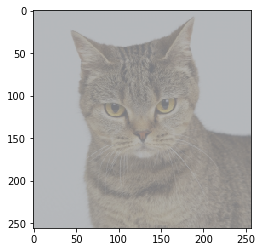

Epoch 1: Content_loss: 0.058523 - Style_loss: 0.005356
Total loss:  0.06387920677661896


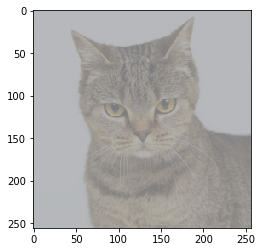

Epoch 2: Content_loss: 0.012363 - Style_loss: 0.006379
Total loss:  0.018741996958851814


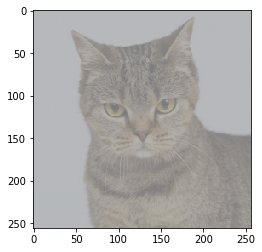

Epoch 3: Content_loss: 0.018504 - Style_loss: 0.007803
Total loss:  0.02630692347884178


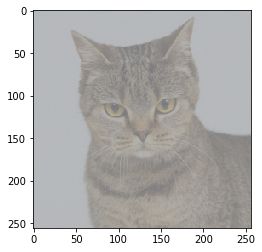

Epoch 4: Content_loss: 0.019298 - Style_loss: 0.008496
Total loss:  0.027793439105153084


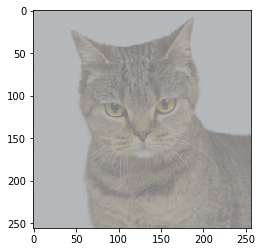

Epoch 5: Content_loss: 0.013425 - Style_loss: 0.008341
Total loss:  0.021765969693660736


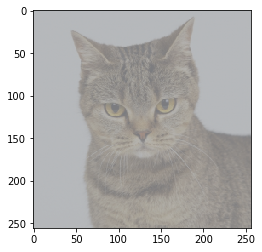

Epoch 6: Content_loss: 0.009201 - Style_loss: 0.007807
Total loss:  0.017007991671562195


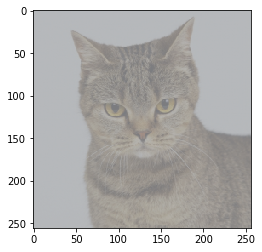

Epoch 7: Content_loss: 0.008365 - Style_loss: 0.007272
Total loss:  0.015637483447790146


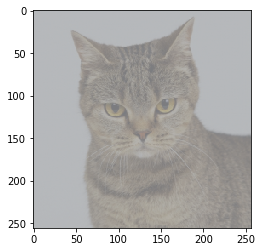

Epoch 8: Content_loss: 0.008521 - Style_loss: 0.006902
Total loss:  0.01542369369417429


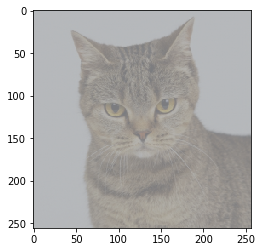

Epoch 9: Content_loss: 0.008147 - Style_loss: 0.006723
Total loss:  0.014870047569274902


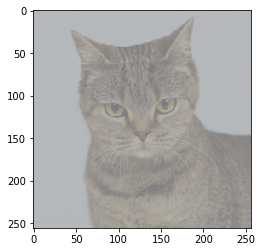

Epoch 10: Content_loss: 0.007186 - Style_loss: 0.006697
Total loss:  0.013883503153920174


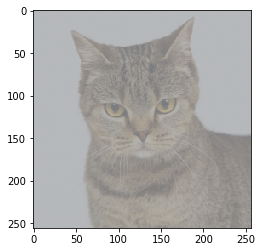

Epoch 11: Content_loss: 0.006146 - Style_loss: 0.006772
Total loss:  0.012917730957269669


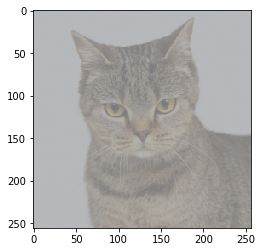

Epoch 12: Content_loss: 0.005220 - Style_loss: 0.006900
Total loss:  0.01211979053914547


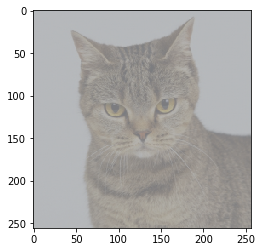

Epoch 13: Content_loss: 0.004473 - Style_loss: 0.007038
Total loss:  0.011511518619954586


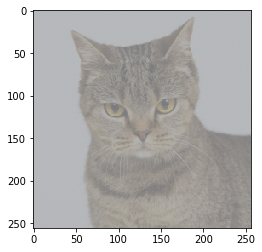

Epoch 14: Content_loss: 0.003914 - Style_loss: 0.007154
Total loss:  0.011067986488342285


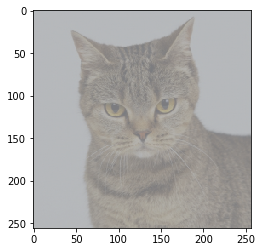

Epoch 15: Content_loss: 0.003535 - Style_loss: 0.007227
Total loss:  0.010762261226773262


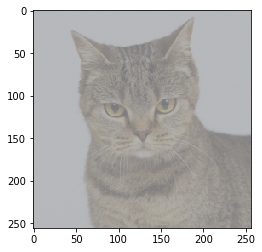

Epoch 16: Content_loss: 0.003239 - Style_loss: 0.007251
Total loss:  0.010489866137504578


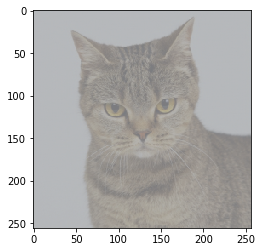

Epoch 17: Content_loss: 0.002919 - Style_loss: 0.007236
Total loss:  0.010154521092772484


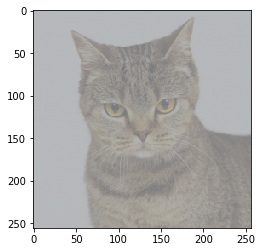

Epoch 18: Content_loss: 0.002632 - Style_loss: 0.007193
Total loss:  0.009825358167290688


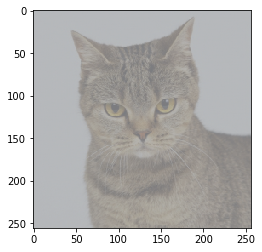

Epoch 19: Content_loss: 0.002426 - Style_loss: 0.007136
Total loss:  0.009561984799802303


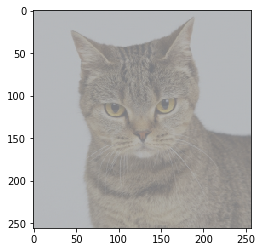

Epoch 20: Content_loss: 0.002279 - Style_loss: 0.007080
Total loss:  0.009358493611216545


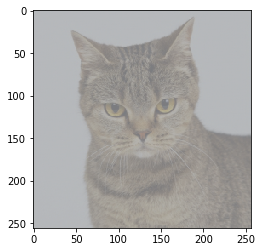

Epoch 21: Content_loss: 0.002116 - Style_loss: 0.007034
Total loss:  0.009149312041699886


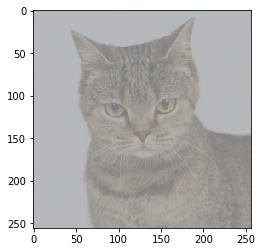

Epoch 22: Content_loss: 0.001965 - Style_loss: 0.007002
Total loss:  0.008966619148850441


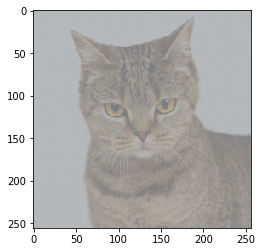

Epoch 23: Content_loss: 0.001837 - Style_loss: 0.006989
Total loss:  0.008826570585370064


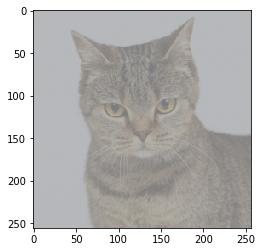

Epoch 24: Content_loss: 0.001720 - Style_loss: 0.006994
Total loss:  0.008713632822036743


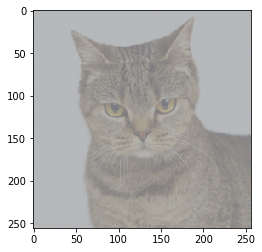

Epoch 25: Content_loss: 0.001587 - Style_loss: 0.007011
Total loss:  0.008598011918365955


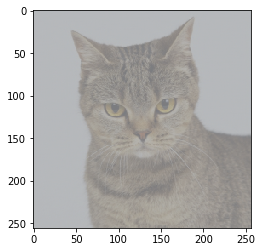

Epoch 26: Content_loss: 0.001443 - Style_loss: 0.007036
Total loss:  0.008478584699332714


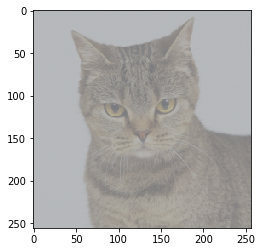

Epoch 27: Content_loss: 0.001300 - Style_loss: 0.007061
Total loss:  0.008360977284610271


KeyboardInterrupt: 

In [23]:
show = 50
steps = 7000  

for ii in range(0, steps+1):
    
    target_features = apply_model_and_extract_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_img_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in weights:
        target_feature = target_features[layer]
        target_gram = calculate_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_features_gram_matrix[layer]
        layer_style_loss = weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show == 0:
        print("Epoch {}: Content_loss: {:4f} - Style_loss: {:4f}".format(ii, content_weight * content_loss,
                                                                        style_weight * style_loss))
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor_to_image(target.clone()))
        plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))